In [1]:
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt
import tqdm
from tqdm import tqdm
import multiprocessing as mp
import seaborn as sns
import pickle

from cvx.stat_arb.ccp import *
from cvx.stat_arb.utils import *
from cvx.stat_arb.backtest import *
from cvx.stat_arb.ar_model import *

sns.set()

%load_ext autoreload
%autoreload 2

In [74]:
prices = pd.read_csv("../data/prices_500_cleaned.csv", index_col=0, header=0, parse_dates=True)
prices.columns = prices.columns.astype(int)
prices = prices.dropna(axis=1, how='any')#.loc[:"1976-01-01"]


# Remove Berkshire Hathaway
# prices = prices.drop([540], axis=1)

# Load sector_to_asset and asset_to_sector from file
with open('../data/sector_to_asset.pkl', 'rb') as f:
    sector_to_asset = pickle.load(f)
with open('../data/asset_to_sector.pkl', 'rb') as f:
    asset_to_sector = pickle.load(f)

# assets = sector_to_asset["Finance and Insurance"]
# assets = [asset for asset in assets if asset in prices.columns]
# prices = prices[assets]

# prices = prices[assets]

# Dynamically managing statistical arbitrages approach

### Find stat arbs and portfolios dynamically

In [76]:
### Batch data
# Look for new stat arbs every update_freq days
update_freq=pd.Timedelta(days=30);
train_len = pd.Timedelta(days=90); 
val_len = pd.Timedelta(days=30);
test_len = pd.Timedelta(days=1000);

t_start = pd.Timestamp("2015-01-01")
t_end = pd.Timestamp("2022-12-31")
# t_start = pd.Timestamp("1970-01-01")
# t_end = pd.Timestamp("1975-12-31")

all_prices_train = []
all_prices_val = []
all_prices_test = []
# Get data for parallelization
n_iters = 0
while t_start < t_end-(train_len):
    n_iters += 1
    
    # Update train, val, test prices
    prices_train = prices.loc[t_start:t_start+train_len-pd.Timedelta(1)]
    prices_val = prices.loc[t_start+train_len:t_start+train_len+val_len-\
        pd.Timedelta(1)]
    prices_test = prices.loc[t_start+train_len+val_len:\
        t_start+train_len+val_len+test_len-pd.Timedelta(1)]

    all_prices_train.append(prices_train)
    all_prices_val.append(prices_val)
    all_prices_test.append(prices_test)

    # Update t_start
    t_start += update_freq

In [79]:
### Solve batched problems
from cvx.stat_arb.ccp import *

np.random.seed(1)

K=10; 
P_max = 15; 
spread_max = 1; 
M=100;
solver="ECOS"
seed = 0

# prices,
#     K=1,
#     P_max=None,
#     spread_max=1,
#     s_init=None,
#     mu_init=None,
#     seed=None,
#     M=None,
#     parallel=False,
#     **kwargs

all_args = zip(
    all_prices_train,
    [K]*n_iters, [P_max]*n_iters, [spread_max]*n_iters,
    [None]*n_iters, [None]*n_iters, [seed]*n_iters,
    [M]*n_iters, [False]*n_iters
    )

pool = mp.Pool()
iterator = tqdm(pool.imap(construct_stat_arbs_parallel, all_args), total=n_iters)
all_groups = []
for group in iterator:
    all_groups.append(group)
pool.close()
pool.join()



100%|██████████| 95/95 [00:41<00:00,  2.27it/s]


In [97]:
# import namedtuple
from collections import namedtuple
ArbGroup = namedtuple("StatARb", ("Arbs", "prices_train", "prices_val", "prices_test"))


profitable_groups = []
unprofitable_groups = []
lin_increase = False
validation_set = False

### Validate stat arb groups and construct portfolios
cutoff_val = 1
cutoff_up_test = 1
cutoff_down_test = 1

all_profits_val = []
all_profits_test = []


SR_cutoff = None
profit_target = 0

all_stat_arbs = []
all_validated_stat_arbs = []
all_stat_arb_daily_profits = []
all_stat_arb_daily_profits_validation = []
portfolio = None # Initialize portfolio
all_validated_groups = []


all_losses_immediate_groups = []
for i, group in tqdm(enumerate(all_groups), total=len(all_groups)):
    

    prices_train, prices_val, prices_test = all_prices_train[i],\
        all_prices_val[i], all_prices_test[i]
    if prices_test.shape[0] == 0:
        continue

    ### Check validation and test set performance
    # for stat_arb in group.stat_arbs:
    #     m_val = stat_arb.metrics(prices_val, cutoff_val, lin_increase=lin_increase)
    #     m_test = stat_arb.metrics(prices_test, cutoff_up_test, cutoff_down_test, lin_increase=lin_increase)
    #     if m_val is not None:
    #         all_profits_val.append(m_val.total_profit)
    #     else:
    #         all_profits_val.append(0)
    #     if m_test is not None:
    #         all_profits_test.append(m_test.total_profit)
    #     else:
    #         all_profits_test.append(0)
    
    prices_train_val = pd.concat([prices_train, prices_val])
    all_stat_arbs += group.stat_arbs

    if validation_set:
        validated_group = group.validate(prices_val,
            prices_train_val, cutoff_val, SR_cutoff, profit_target=profit_target, P_max=None)   
    else:
        validated_group = group
        prices_test = pd.concat([prices_val, prices_test])
    all_validated_stat_arbs += validated_group.stat_arbs
    
    ### Test-set stuff
    profitable_stat_arbs = []
    unprofitable_stat_arbs = []
    losses_immediate = []
    for stat_arb in validated_group.stat_arbs:
        m = stat_arb.metrics(prices_test, cutoff_up_test,\
            cutoff_down_test, lin_increase=lin_increase)
        if m is not None:
            all_stat_arb_daily_profits.append(m.daily_profit)   

            # TODO: 
            m_val = stat_arb.metrics(prices_val, cutoff_up_test,\
                cutoff_down_test, lin_increase=lin_increase)
            all_stat_arb_daily_profits_validation.append(m_val.daily_profit)

            if m.total_profit > 0:
                profitable_stat_arbs.append(stat_arb)
            else:
                unprofitable_stat_arbs.append(stat_arb)
            if m.daily_profit[1] == 0:
                # print(m.daily_profit[0])
                losses_immediate.append(stat_arb)
    all_losses_immediate_groups.append(ArbGroup(StatArbGroup(losses_immediate), prices_train, prices_val, prices_test))

    profitable_groups.append(ArbGroup(StatArbGroup(profitable_stat_arbs), prices_train, prices_val, prices_test))
    
    unprofitable_groups.append(ArbGroup(StatArbGroup(unprofitable_stat_arbs), prices_train, prices_val, prices_test))

    # # Construct portfolio
    if portfolio is None:
        portfolio = validated_group.construct_portfolio(prices_test, cutoff_up_test, cutoff_down_test, lin_increase=lin_increase)
        all_portfolios = [portfolio]
    else:
        portfolio_new = validated_group.construct_portfolio(prices_test,\
                                                            cutoff_up_test,
                                                            cutoff_down_test,
                                                            lin_increase=lin_increase)
        if portfolio_new is not None:
            portfolio += portfolio_new
            all_portfolios.append(portfolio_new)
    all_validated_groups.append(validated_group)


100%|██████████| 95/95 [01:17<00:00,  1.22it/s]


Correlation:  -0.04345598574306416


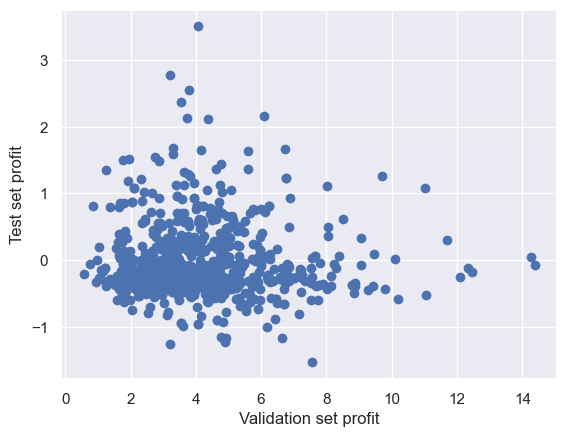

In [98]:
daily_profs_test = [np.sum(x) for x in all_stat_arb_daily_profits]
daily_profs_val = [np.sum(x) for x in all_stat_arb_daily_profits_validation]
plt.scatter(daily_profs_val, daily_profs_test)
plt.xlabel("Validation set profit")
plt.ylabel("Test set profit");
print("Correlation: ", np.corrcoef(daily_profs_val, daily_profs_test)[0,1])

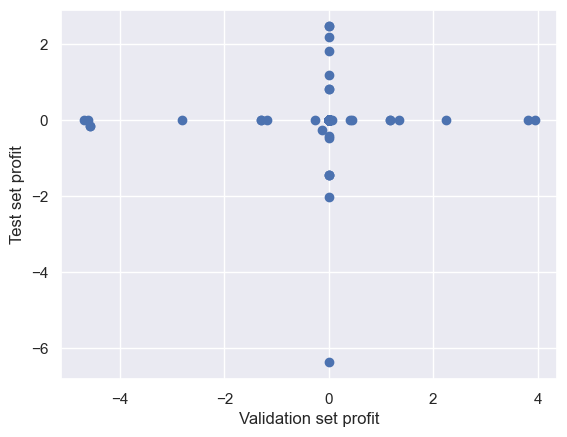

In [29]:
### Good? strategy

plt.scatter(all_profits_val, all_profits_test)
plt.xlabel("Validation set profit")
plt.ylabel("Test set profit");

Text(0, 0.5, 'Test set profit')

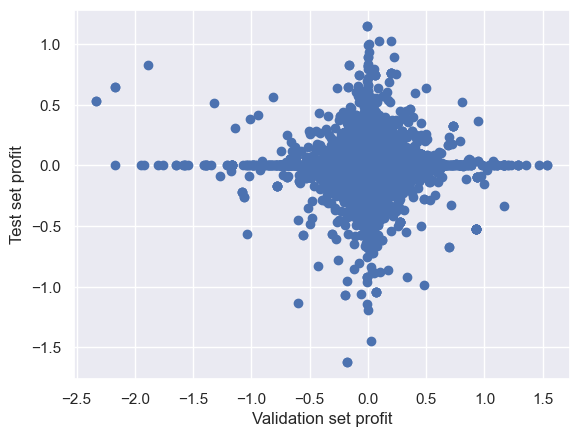

In [70]:
### Bad strategy

plt.scatter(all_profits_val, all_profits_test)
plt.xlabel("Validation set profit")
plt.ylabel("Test set profit")

### Example SA trajectories

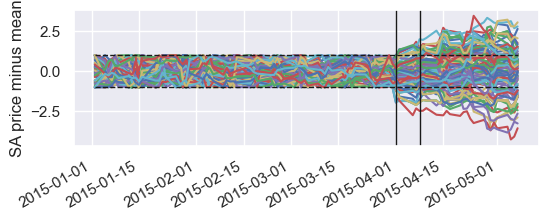

In [21]:
plot_all_portfolios(all_groups[0].stat_arbs, all_prices_train[0], all_prices_val[0], all_prices_test[0])
plt.gcf().autofmt_xdate()
# define figure size
fig = plt.gcf()
fig.set_size_inches(6, 2)
plt.ylabel("SA price minus mean");

In [53]:
profs = []
for port in all_portfolios:
    m = Metrics(port.profit)
    print("\n", port.stocks.index[0])
    print("profit: ", np.round(m.total_profit,2))
    print("SR: ", np.round(m.sr_profit,2))
    # profs.append(m.total_profit)


 2015-05-01 00:00:00
profit:  -0.72
SR:  -2.78

 2015-06-01 00:00:00
profit:  0.94
SR:  4.14

 2015-06-30 00:00:00
profit:  -1.31
SR:  -2.97

 2015-07-30 00:00:00
profit:  1.9
SR:  3.6

 2015-08-31 00:00:00
profit:  1.95
SR:  3.05

 2015-09-28 00:00:00
profit:  -3.28
SR:  -5.38

 2015-10-28 00:00:00
profit:  -0.06
SR:  -0.55

 2015-11-27 00:00:00
profit:  0.19
SR:  0.51

 2015-12-28 00:00:00
profit:  3.77
SR:  6.75

 2016-01-26 00:00:00
profit:  0.14
SR:  0.16

 2016-02-25 00:00:00
profit:  -1.02
SR:  -2.47

 2016-03-28 00:00:00
profit:  -0.9
SR:  -7.34

 2016-04-25 00:00:00
profit:  0.11
SR:  0.97

 2016-05-25 00:00:00
profit:  -0.32
SR:  -2.36

 2016-06-24 00:00:00
profit:  -1.05
SR:  -5.75

 2016-07-25 00:00:00
profit:  0.75
SR:  9.99

 2016-08-23 00:00:00
profit:  0.03
SR:  0.14

 2016-09-22 00:00:00
profit:  1.34
SR:  4.78

 2016-10-24 00:00:00
profit:  -0.58
SR:  -1.75

 2016-11-21 00:00:00
profit:  0.36
SR:  1.98

 2016-12-21 00:00:00
profit:  -0.66
SR:  -4.41

 2017-01-20 00:0

In [426]:
all_alphas_train_val = []
all_alphas_test = []
for i in range(len(all_groups)):
    group = all_groups[i]
    prices_train, prices_val, prices_test = all_prices_train[i],\
        all_prices_val[i], all_prices_test[i]
    if prices_test.shape[0] == 0:
        continue
    prices_train_val = pd.concat([prices_train, prices_val])

    for stat_arb in group.stat_arbs:
        alpha_train_val, _, _ = ar(stat_arb, prices_train_val)
        all_alphas_train_val.append(alpha_train_val)

        alpha_test, _, _ = ar(stat_arb, prices_test)
        all_alphas_test.append(alpha_test)
    

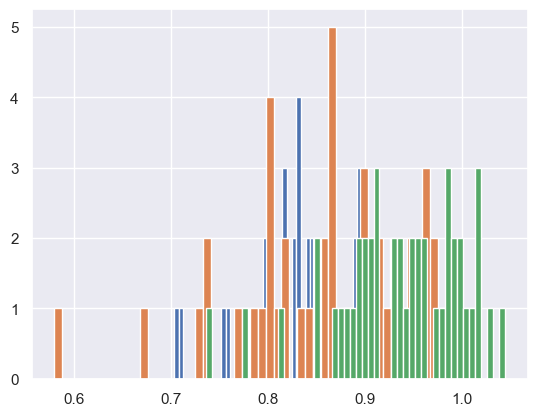

In [424]:
plt.hist(profitable_alpha_train, bins=50)
plt.hist(profitable_alpha_val, bins=50);
plt.hist(profitable_alpha_test, bins=50);

In [427]:
profitable_omega_train = []
profitable_omega_val = []
profitable_alpha_train = []
profitable_alpha_val = []
profitable_alpha_test = []
for group in profitable_groups:
    for stat_arb in group.Arbs.stat_arbs:
        alpha_train, sigma_train, _ = ar(stat_arb, group.prices_train)
        alpha_val, sigma_val, _ = ar(stat_arb, group.prices_val)
        alpha_test, sigma_test, _ = ar(stat_arb, group.prices_test)

        profitable_alpha_train.append(alpha_train)
        profitable_alpha_val.append(alpha_val)
        profitable_alpha_test.append(alpha_test)

        omega_train = sigma_train**2 / (1-alpha_train**2)
        omega_val = sigma_val**2 / (1-alpha_val**2)

        profitable_omega_train.append(omega_train)
        profitable_omega_val.append(omega_val)

profitable_omega_train = np.array(profitable_omega_train)
profitable_omega_val = np.array(profitable_omega_val)

unprofitable_omega_train = []
unprofitable_omega_val = []

for group in unprofitable_groups:
    for stat_arb in group.Arbs.stat_arbs:
        alpha_train, sigma_train, _ = ar(stat_arb, group.prices_train)
        alpha_val, sigma_val, _ = ar(stat_arb, group.prices_val)

        omega_train = sigma_train**2 / (1-alpha_train**2)
        omega_val = sigma_val**2 / (1-alpha_val**2)

        unprofitable_omega_train.append(omega_train)
        unprofitable_omega_val.append(omega_val)

unprofitable_omega_train = np.array(unprofitable_omega_train)
unprofitable_omega_val = np.array(unprofitable_omega_val)


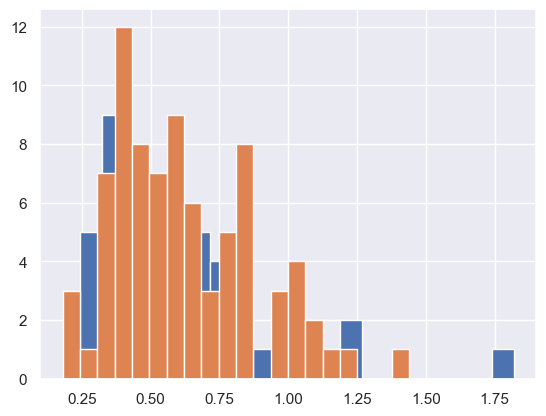

In [418]:
plt.hist(profitable_omega_val/profitable_omega_train, bins=20);
plt.hist(unprofitable_omega_val/unprofitable_omega_train, bins=20);




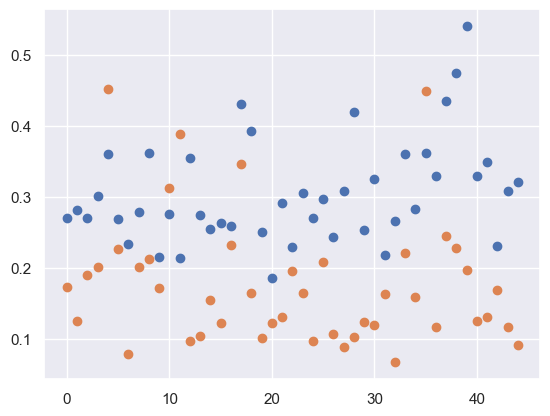

In [404]:
plt.scatter(np.arange(len(profitable_omega_train)), profitable_omega_train)
plt.scatter(np.arange(len(profitable_omega_val)), profitable_omega_val);

In [ ]:
plt.scatter()

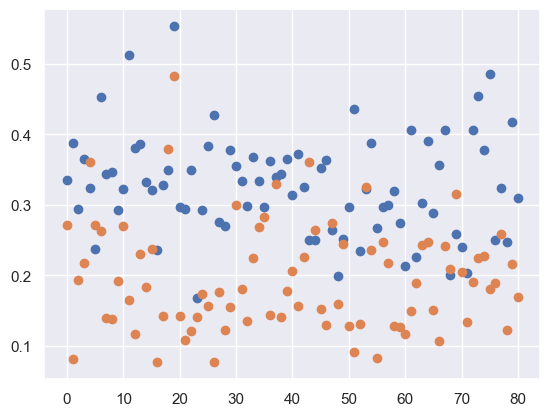

In [405]:
plt.scatter(np.arange(len(unprofitable_omega_train)), unprofitable_omega_train)
plt.scatter(np.arange(len(unprofitable_omega_val)), unprofitable_omega_val);

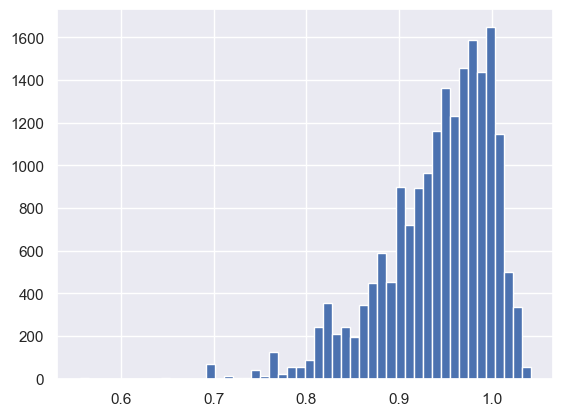

In [396]:
plt.hist(all_alphas_train_val, bins=50);

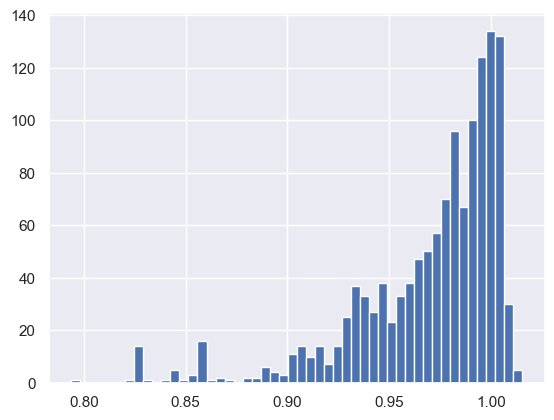

In [ ]:
plt.hist(all_alphas_train_val, bins=50);

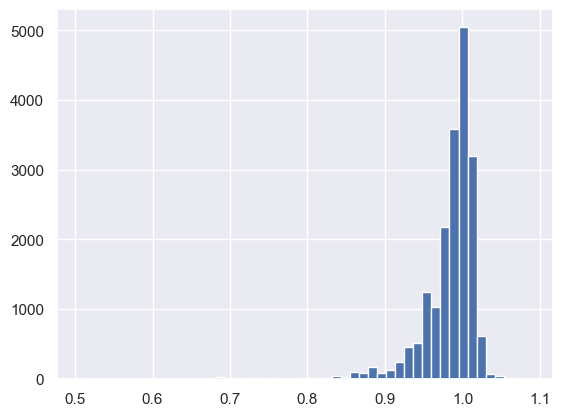

In [397]:
plt.hist(all_alphas_test, bins=50);

In [11]:
stat_arbs = profitable_groups[0].Arbs.stat_arbs
prices_train = profitable_groups[0].prices_train
prices_val = profitable_groups[0].prices_val
prices_test = profitable_groups[0].prices_test

alpha1, price_hat1 = ar(stat_arbs[0], pd.concat([prices_train, prices_val]))
alpha2, price_hat2 = ar(stat_arbs[1], pd.concat([prices_train, prices_val]))

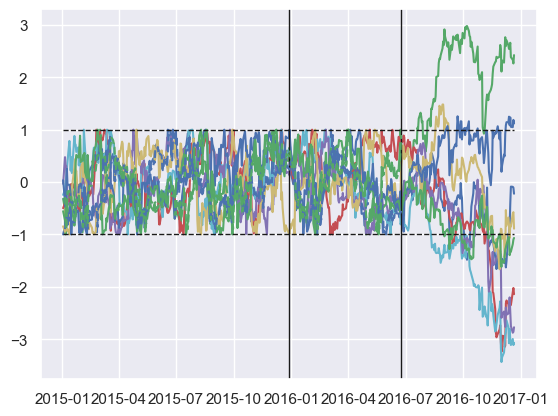

In [12]:
plot_all_portfolios(stat_arbs, prices_train, prices_val, prices_test)
plt.plot(price_hat1, "--", c="b")
plt.plot(price_hat2, "--", c="g")

### Plot profitable groups

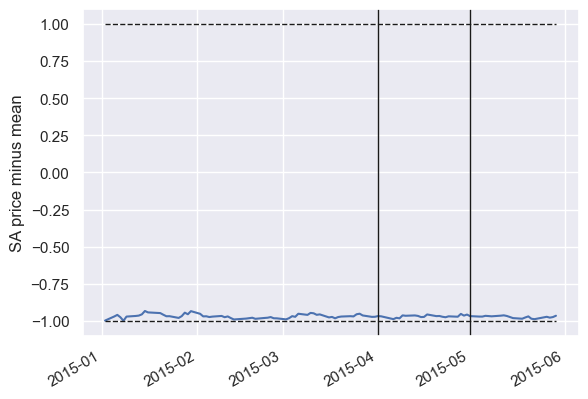

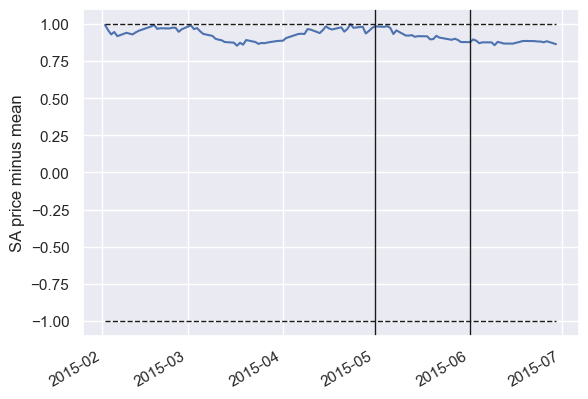

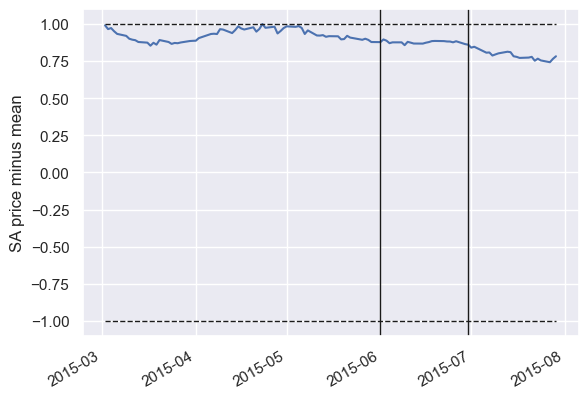

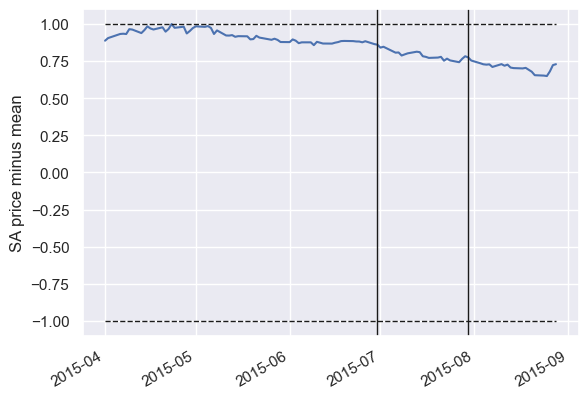

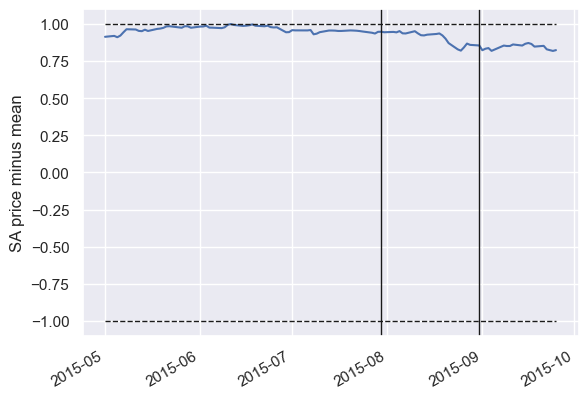

In [54]:
for i in range(5):
    for group in profitable_groups[i:i+1]:
        try:
            plt.figure()
            plot_all_portfolios([group.Arbs.stat_arbs[0]], group.prices_train, group.prices_val, group.prices_test)
            plt.gcf().autofmt_xdate()
            plt.ylabel("SA price minus mean")
        except:
            pass
        # plt.savefig(f"/Users/kasper/Documents/Stanford/Research/My papers/stat_arbs/cvx_ccv_stat_arb/paper/figures/profitable_SA_{i}.png")

### Plot unprofitable groups

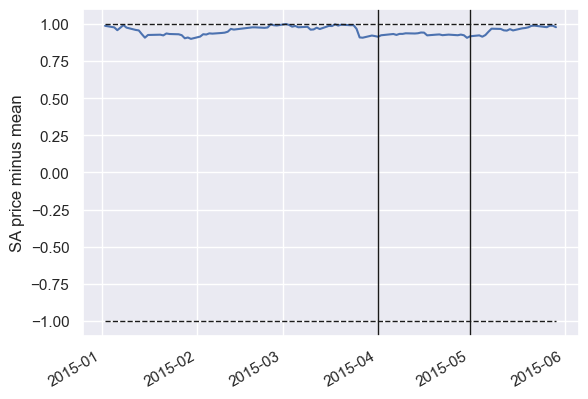

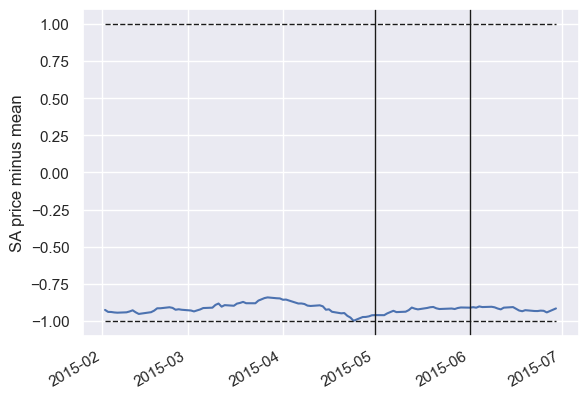

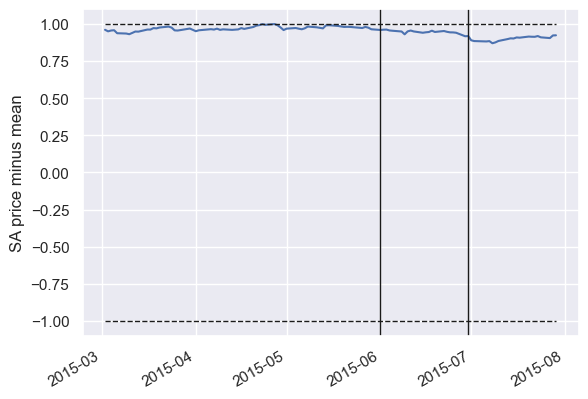

In [55]:
for i in range(3):
    for group in unprofitable_groups[i:i+1]:
        try:
            plt.figure()
            plot_all_portfolios([group.Arbs.stat_arbs[0]], group.prices_train, group.prices_val, group.prices_test)
            plt.gcf().autofmt_xdate()
            plt.ylabel("SA price minus mean")
        except:
            pass
        # plt.savefig(f"/Users/kasper/Documents/Stanford/Research/My papers/stat_arbs/cvx_ccv_stat_arb/paper/figures/unprofitable_SA_{i}.png")

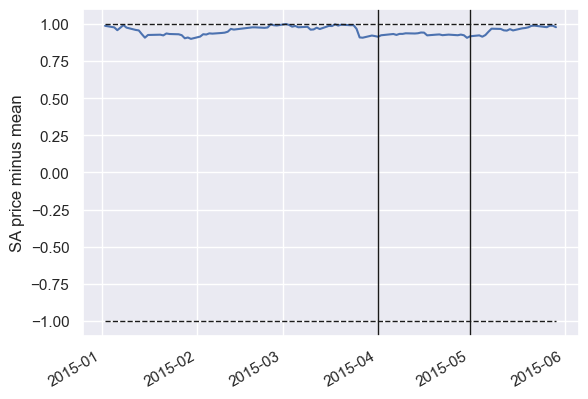

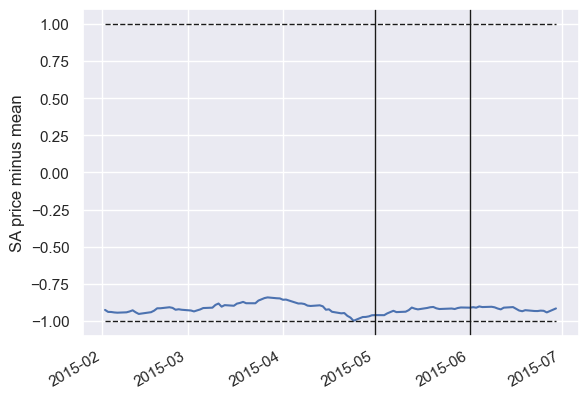

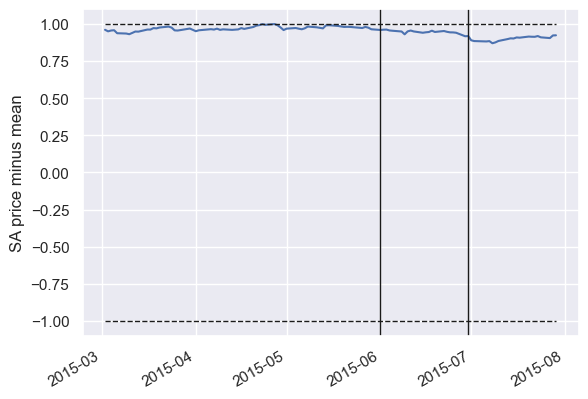

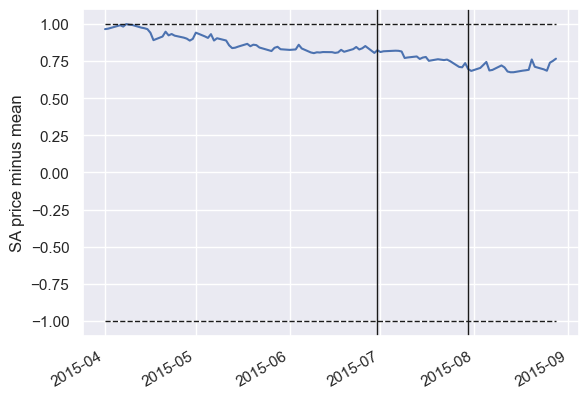

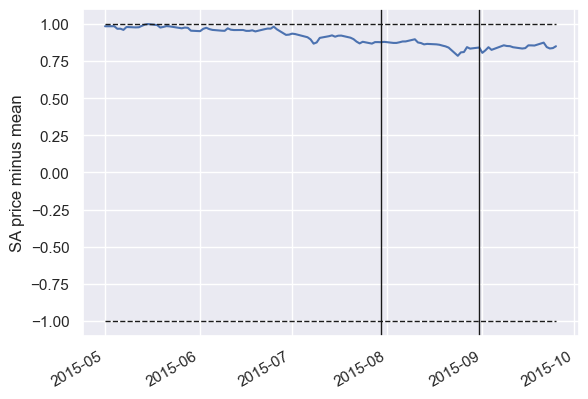

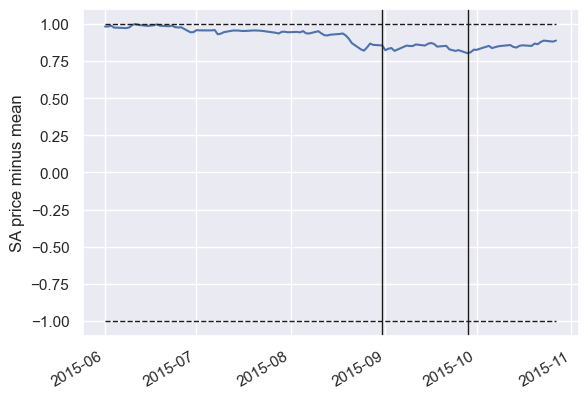

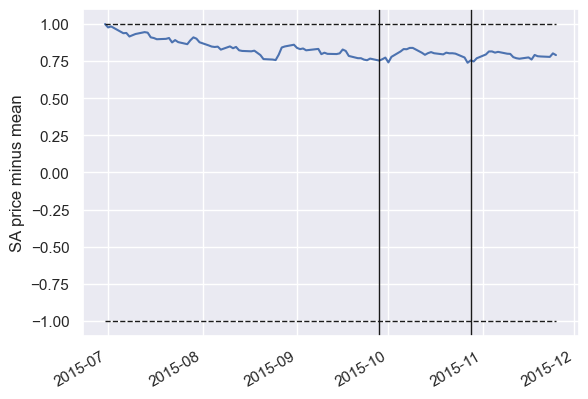

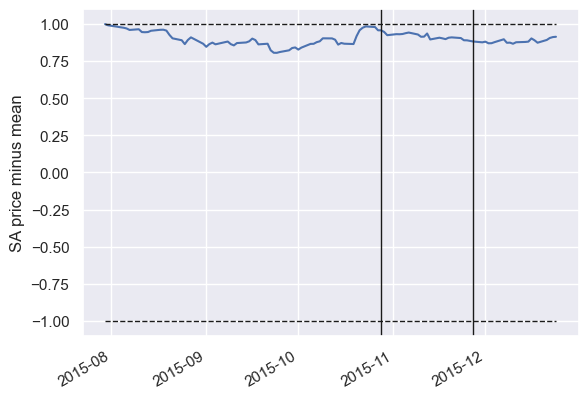

In [56]:
for i in range(8):
    for group in unprofitable_groups[i:i+1]:
        try:
            plt.figure()
            plot_all_portfolios([group.Arbs.stat_arbs[0]], group.prices_train, group.prices_val, group.prices_test)
            plt.gcf().autofmt_xdate()
            plt.ylabel("SA price minus mean")
        except:
            pass
        # plt.savefig(f"/Users/kasper/Documents/Stanford/Research/My papers/stat_arbs/cvx_ccv_stat_arb/paper/figures/unprofitable_SA_{i}.png")

In [82]:
lens = [len(arb.asset_names) for arb in all_stat_arbs]
lens_validated = [len(arb.asset_names) for arb in all_validated_stat_arbs]

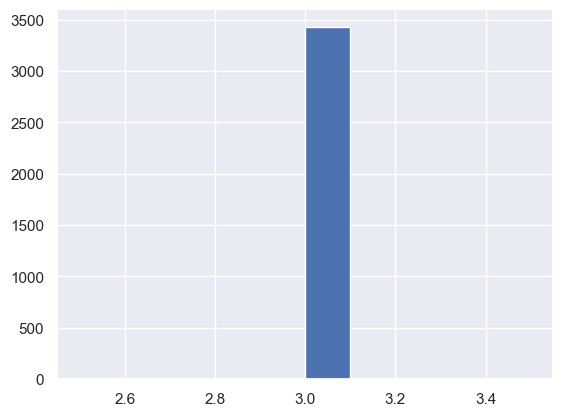

In [58]:
plt.hist(lens_validated);

In [83]:
len(all_validated_stat_arbs)

940

In [84]:
len(all_stat_arbs)

940

In [85]:
np.mean(lens_validated)

3.125531914893617

In [86]:
### Uniform portfolio benchmark
start_date = portfolio.stocks.index[0]
end_date = portfolio.stocks.index[-1]
prices_unif = prices.loc[start_date:end_date]
stocks_unif = pd.DataFrame(np.ones_like(prices_unif)/len(prices_unif.columns), index=prices_unif.index, columns=prices_unif.columns)
portfolio_unif = EquityPortfolio(prices_unif, stocks_unif, initial_cash=portfolio.initial_cash)

In [87]:
m_unif = Metrics(portfolio_unif.profit)
print("profit uniform: ", np.round(m_unif.total_profit,2))
print("SR uniform: ", np.round(m_unif.sr_profit,2))

profit uniform:  377.73
SR uniform:  0.5


In [88]:
m = Metrics(portfolio.profit)
print("profit: ", np.round(m.total_profit,2))
print("SR: ", np.round(m.sr_profit,2))

profit:  -24.55
SR:  -0.5


In [89]:
np.corrcoef(portfolio.profit, portfolio_unif.profit[portfolio.profit.index])

array([[ 1.        , -0.01597803],
       [-0.01597803,  1.        ]])

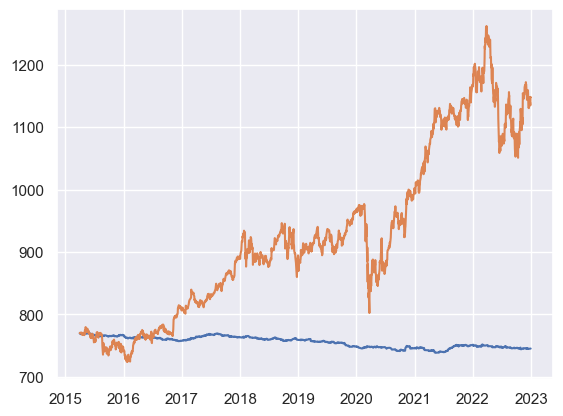

In [90]:
plt.plot(portfolio.nav)
plt.plot(portfolio_unif.nav)

<Axes: xlabel='date'>

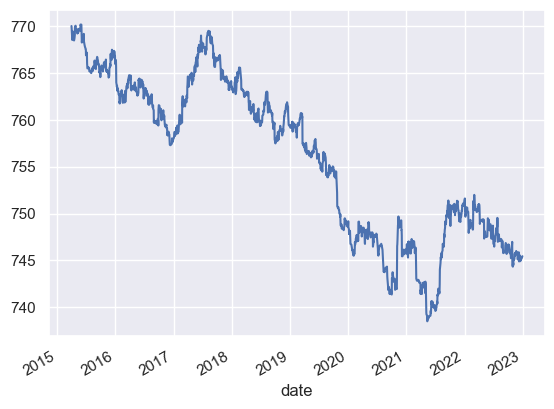

In [91]:
portfolio.nav.plot()

Avg profit:  -0.032


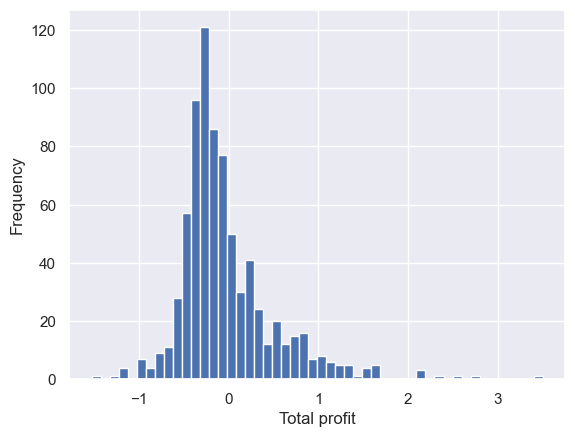

In [92]:
all_total_profits = []
for daily_profit in all_stat_arb_daily_profits:
    all_total_profits.append(daily_profit.sum())
# histogram
plt.hist(all_total_profits, bins=50);
print("Avg profit: ", np.mean(all_total_profits).round(3))
plt.xlabel("Total profit")
plt.ylabel("Frequency");

In [93]:
wins = []
losses = []
for total_profit in all_total_profits:
    if total_profit > 0:
        wins.append(total_profit)
    else:
        losses.append(total_profit)
print("Avg win: ", np.mean(wins).round(3))
print("Avg loss: ", np.mean(losses).round(3))

Avg win:  0.533
Avg loss:  -0.32


In [94]:
prof_test = [np.sum(x) for x in all_stat_arb_daily_profits]
prof_val = [np.sum(x) for x in all_stat_arb_daily_profits_validation]

In [95]:
np.corrcoef(prof_test, prof_val)

array([[1.        , 0.88401654],
       [0.88401654, 1.        ]])

48% profitable


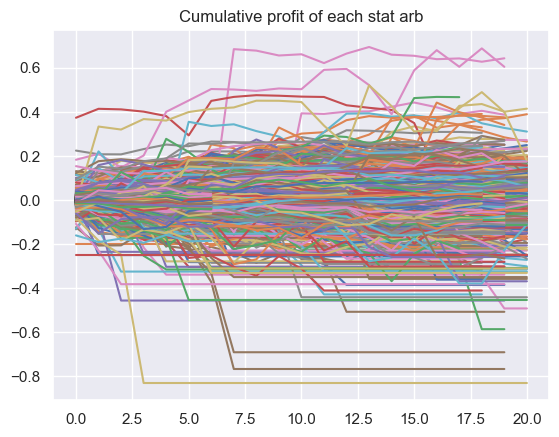

In [73]:
n_profitable = 0
avg_profits = np.zeros(180)
for profit in all_stat_arb_daily_profits:
    plt.plot(profit.cumsum().values)
    if profit.sum() > 0:
        n_profitable += 1
    avg_profits[:len(profit)] += profit
avg_profits /= len(all_stat_arb_daily_profits)
avg_profits[0] = 0
plt.title("Cumulative profit of each stat arb");
print(f"{n_profitable/len(all_stat_arb_daily_profits):.0%} profitable")

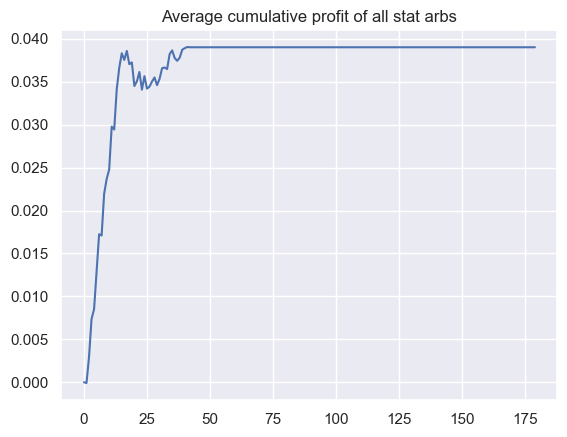

In [22]:
plt.plot(np.cumsum(avg_profits));
plt.title("Average cumulative profit of all stat arbs");

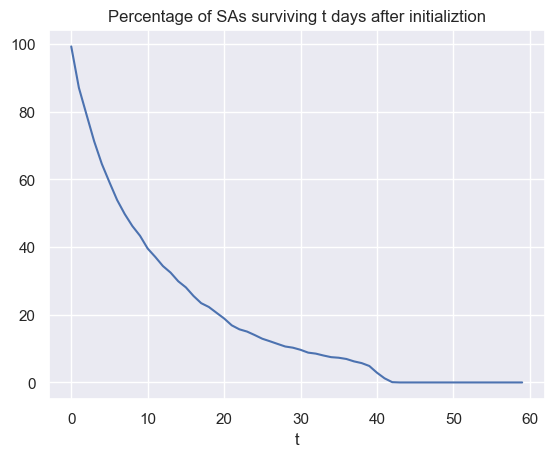

In [23]:
# Find number of survivers as a function of time
n_survivers = []
n_stat_arbs = len(all_stat_arb_daily_profits)
for i in range(60):
    n = 0
    for profit in all_stat_arb_daily_profits:
        if len(profit) > i:
            if profit[i] !=0:
                n+=1

    n_survivers.append(n/n_stat_arbs*100)

plt.plot(n_survivers); plt.title("Percentage of SAs surviving t days after initializtion"); plt.xlabel("t");

In [367]:
np.mean(n_survivers)

51.17449664429531

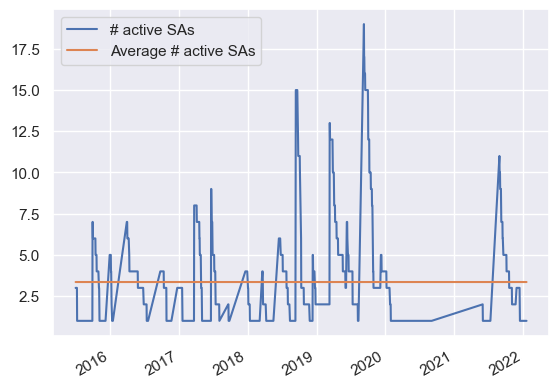

In [260]:
# Find number of active stat arbs at each time step
n_active = {}

for profit in all_stat_arb_daily_profits:
    for i in range(len(profit)):
        if profit[i] != 0:
            if profit.index[i] in n_active:
                n_active[profit.index[i]] += 1
            else:
                n_active[profit.index[i]] = 1

time_steps = list(n_active.keys())
n_active = list(n_active.values())

plt.plot(time_steps, n_active, label="# active SAs");
# plot average active
avg_active = np.mean(n_active)
plt.plot(time_steps, [avg_active]*len(time_steps), label="Average # active SAs")
plt.legend()

plt.gcf().autofmt_xdate();


### Sum portfolios

### Metrics

In [261]:
m = Metrics(portfolio.profit)
print("profit: ", np.round(m.total_profit,2))
print("SR: ", np.round(m.sr_profit,2))

profit:  61.75
SR:  0.72


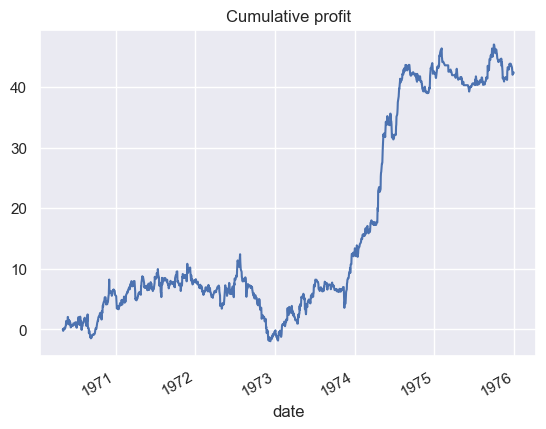

In [27]:
portfolio.profit.cumsum().plot()
plt.title("Cumulative profit");

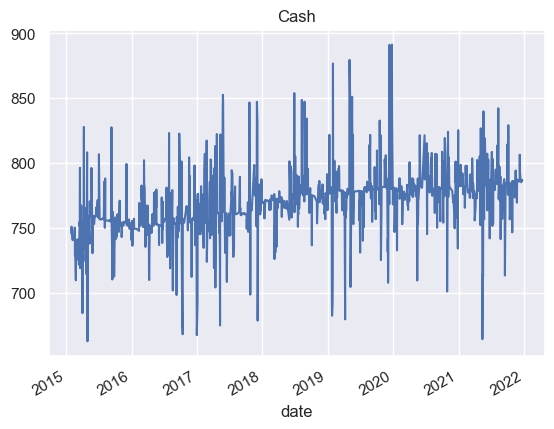

In [191]:
portfolio.cash.plot()
plt.title("Cash");

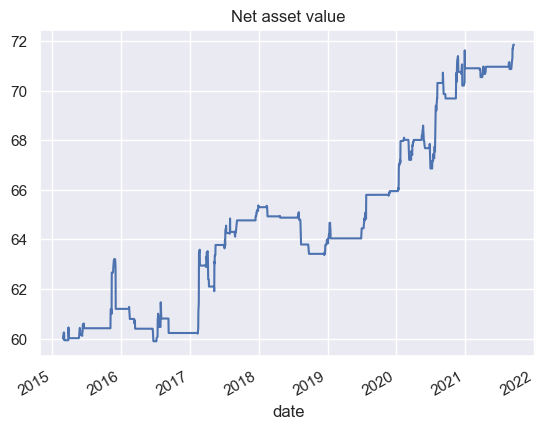

In [146]:
portfolio.nav.plot()
plt.title("Net asset value");

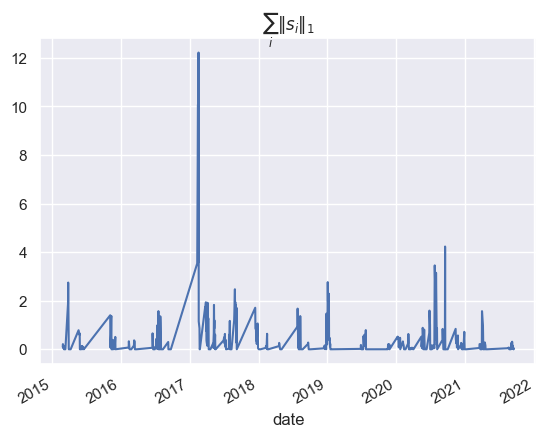

In [147]:
portfolio.stocks.abs().sum(axis=1).plot()
plt.title(r"$\sum_i\|s_i\|_1$");

(-10.0, 10.0)

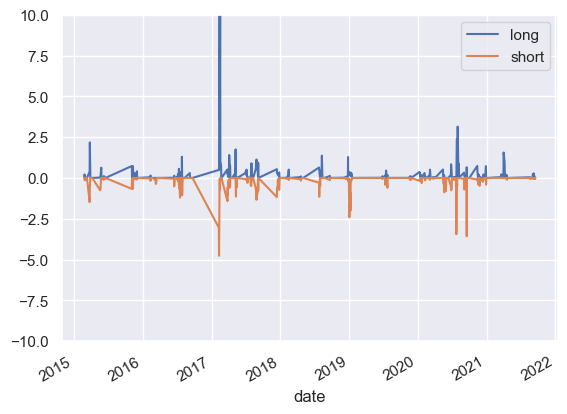

In [149]:
# Plot long positions
portfolio.stocks[portfolio.stocks>0].sum(axis=1).plot(label="long")
portfolio.stocks[portfolio.stocks<0].sum(axis=1).plot(label="short");
plt.legend();
plt.ylim(-10,10)

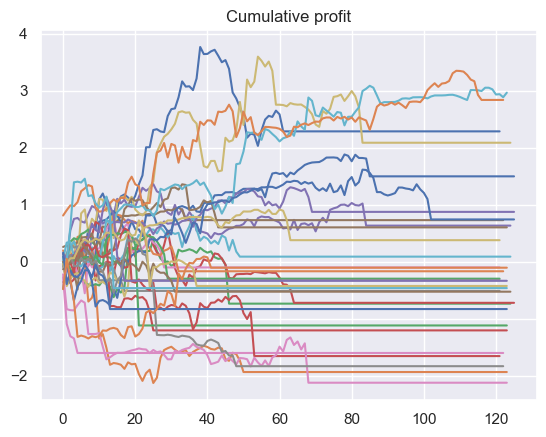

In [139]:
# Individual stat arb groups
for portfolio in all_portfolios:
    if portfolio is not None:
        m = Metrics(portfolio.profit)
        plt.plot(m.daily_profit.cumsum().values)
plt.title("Cumulative profit");